In [ ]:
import torch
from torch.utils.data import DataLoader, random_split, Subset
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import torchvision
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
import numpy as np
from utils import * 
from training_utils import *

In [10]:
img_size = 224

root_dir = '../DL_project/hoop_training_imgs'
temp_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(root=root_dir, transform = temp_transforms)
# check class balance
class_names = dataset.classes

class_count = {}
for i in range(len(class_names)):
    class_count[class_names[i]] = 0
for img, label in dataset:
    class_count[class_names[label]] += 1
print(class_count)
def calculate_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0

    for data, _ in loader:
        # Mean over batch, height, and width, but not over the channels
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches
    # Var(X) = E[X^2] - E[X]^2
    std = (channels_squared_sum / num_batches - mean**2)**0.5

    return mean, std

# Calculate mean and std
mean, std = calculate_mean_std(DataLoader(dataset, batch_size=128, shuffle=True, num_workers = 4))
print(f"Mean: {mean}")
print(f"Std: {std}")

{'0': 4361, '1': 2146}
Mean: tensor([0.5775, 0.5072, 0.4553])
Std: tensor([0.2236, 0.2230, 0.2123])


In [13]:
dataset = datasets.ImageFolder(root=root_dir, transform = temp_transforms)
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  # Resize the images to 224x224
    transforms.RandomRotation(degrees=10),  # Randomly rotate images by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # Randomly changes brightness, contrast, and saturation
    transforms.RandomAdjustSharpness(sharpness_factor=2),  # Randomly adjust the sharpness
    transforms.ToTensor(),  # Convert the PIL Image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean=mean, std=std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # transforms.Normalize(mean=mean, std=std),
])

batch_size = 64


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_dataset.dataset.transform = train_transforms
valid_dataset.dataset.transform = val_test_transforms
test_dataset.dataset.transform = val_test_transforms



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)






# train_dataset = datasets.ImageFolder(root='data/classification_dataset_groupby_env_split/train', transform=train_transforms)
# valid_dataset = datasets.ImageFolder(root='data/classification_dataset_groupby_env_split/val', transform=val_test_transforms)
# test_dataset = datasets.ImageFolder(root='data/classification_dataset_groupby_env_split/test', transform=val_test_transforms)

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


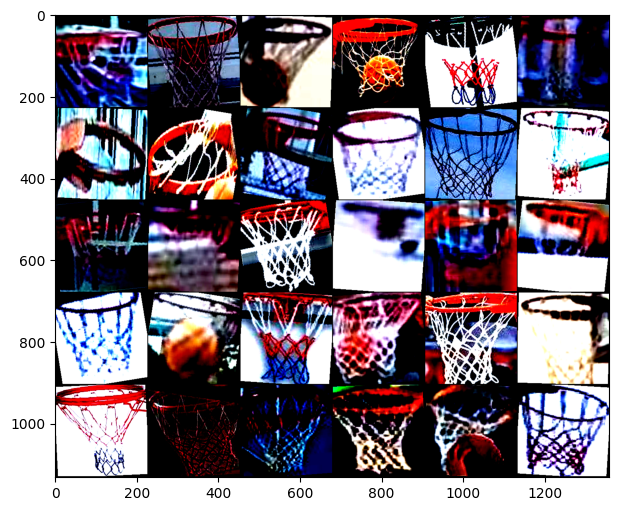

In [14]:
def imshow(img, figsize=(12, 6)):
    plt.figure(figsize=figsize)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def visualize_transform(train_transforms = train_transforms, root_dir = None, subset_size = 30 ):
    subset_dataset = datasets.ImageFolder(root=root_dir, transform=train_transforms)

    # Select 30 random images from the subset
    subset_size = 30  # Number of images to display
    subset_indices = torch.randperm(len(subset_dataset))[:subset_size]

    # Using Subset to create a smaller dataset
    visualize_subset = torch.utils.data.Subset(subset_dataset, subset_indices)

    # DataLoader for the subset
    visualize_loader = DataLoader(visualize_subset, batch_size=subset_size, shuffle=False)

    # Retrieve the images from the loader
    images_transformed, _ = next(iter(visualize_loader))

    # Convert the images to a grid
    images_grid = torchvision.utils.make_grid(images_transformed, nrow=6, padding=2)
    imshow(images_grid)
visualize_transform(root_dir="data/classification_dataset_groupby_env_split/train")

In [2]:
config = {
    'lr': 0.002,
    'batch_size': 128,
    'optimizer': 'sgd',
    'img_size': 224,
    'nestrov': True,
    'momentum': 0.8,
    'normalize': transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    # 'scheduler_config': {
    #     'step_size': 40,
    #     'gamma': 0.5
    # }
 }


model, history, test_loader = train(config, 
                                    num_epochs=150, 
                                    chkpt_interval=5, 
                                    checkpoint_dir='./cls_chkpoint_resnet18', 
                                    early_stopping_patience=20, 
                                    resume_checkpoint_path=None, 
                                    device = "cuda:0",
                                    model_type = "resnet18",
                                    root_data_dir = 'data/classification_dataset_groupby_env_split',
                                    already_split=True,
                                    )

Ep[1/150]  [train loss]: 0.0055  [Val Loss]: 0.0070  [Best Loss]: inf  [TestAcc]: 0.5709  [Time]: 16.81
Ep[2/150]  [train loss]: 0.0048  [Val Loss]: 0.0062  [Best Loss]: 0.0070  [TestAcc]: 0.6945  [Time]: 5.06
Ep[4/150]  [train loss]: 0.0037  [Val Loss]: 0.0056  [Best Loss]: 0.0060  [TestAcc]: 0.7382  [Time]: 7.01
Ep[6/150]  [train loss]: 0.0028  [Val Loss]: 0.0045  [Best Loss]: 0.0053  [TestAcc]: 0.7818  [Time]: 5.10
Ep[8/150]  [train loss]: 0.0022  [Val Loss]: 0.0041  [Best Loss]: 0.0045  [TestAcc]: 0.8109  [Time]: 5.10
Ep[10/150]  [train loss]: 0.0016  [Val Loss]: 0.0040  [Best Loss]: 0.0041  [TestAcc]: 0.8036  [Time]: 5.05
Ep[12/150]  [train loss]: 0.0014  [Val Loss]: 0.0038  [Best Loss]: 0.0040  [TestAcc]: 0.8327  [Time]: 4.88
Ep[14/150]  [train loss]: 0.0011  [Val Loss]: 0.0034  [Best Loss]: 0.0034  [TestAcc]: 0.8400  [Time]: 4.70
Ep[16/150]  [train loss]: 0.0009  [Val Loss]: 0.0038  [Best Loss]: 0.0034  [TestAcc]: 0.8545  [Time]: 4.96
Ep[18/150]  [train loss]: 0.0008  [Val Loss]

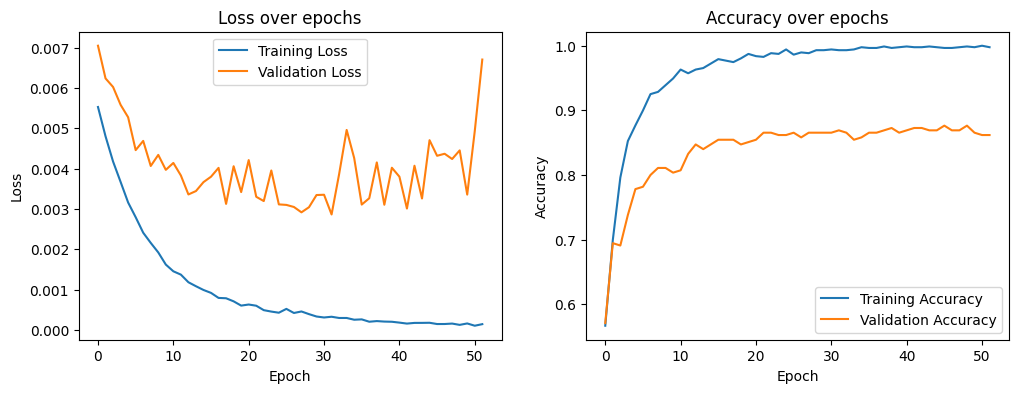

In [3]:
#plot_training_history(0, "cls_chkpoint_resnet18/checkpoint_2023-12-24-15-10_lr_0.0001_batch_64/history.json")
plot_training_history(history)

# Testing models

100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


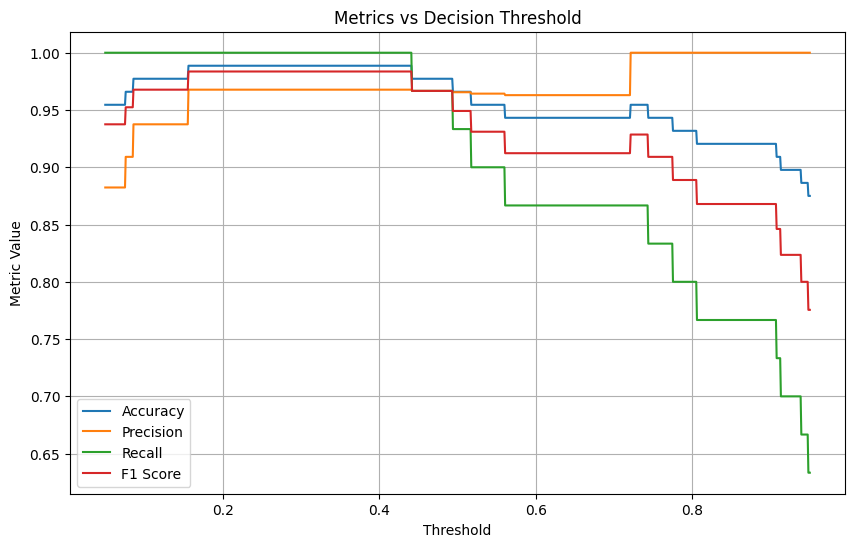

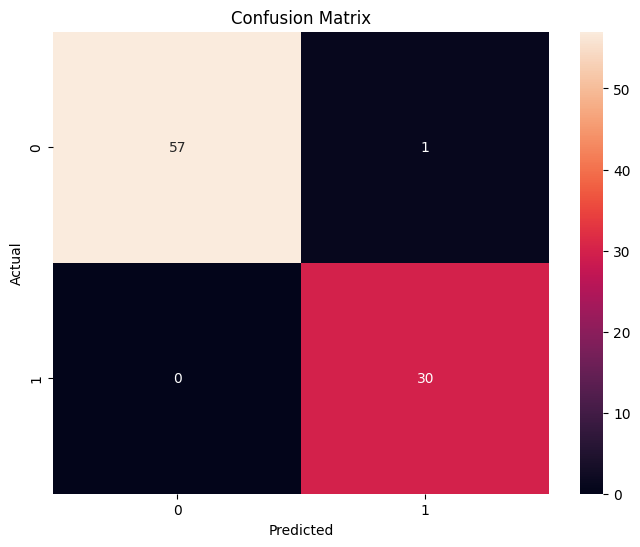

In [4]:
#model = load_resnet18("cls_chkpoint_resnet18/checkpoint_2024-01-01-22-28_lr_0.003_batch_128/checkpoint_2024-01-01-22-28_lr_0.003_batch_128/checkpoint_epoch_15.pth", 1)
all_probs, all_labels = plot_PR_curve(model, test_loader)
plot_confusion_matrix(all_probs, all_labels, threshold=0.2)

In [14]:


def show_feature_map(model, image_path, device = "cuda"):
    img = Image.open(image_path)

    feature_maps = []

    def hook_function(module, input, output):
        feature_maps.append(output)

    # Register the hook to the first convolutional layer of the first block of layer1
    hook = model.layer1[0].conv1.register_forward_hook(hook_function)

    # Load an image


    # Preprocess the image
    preprocess = transforms.Compose([
        transforms.Resize(112),
        transforms.ToTensor(),
    ])
    img_tensor = preprocess(img).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model(img_tensor)

    # Unregister the hook
    hook.remove()

    # Visualize the feature maps
    fm = feature_maps[0].squeeze(0)  # Get the feature maps

    # Plotting
    fig, axes = plt.subplots(8, 8, figsize=(20, 20))  # Adjust subplot dimensions as needed
    for i, ax in enumerate(axes.flat):
        if i < 64:  # Adjust this based on how many feature maps you want to visualize
            ax.imshow(fm[i].detach().cpu().numpy(), cmap='viridis')
            ax.axis('off')
    plt.tight_layout()
    plt.show()





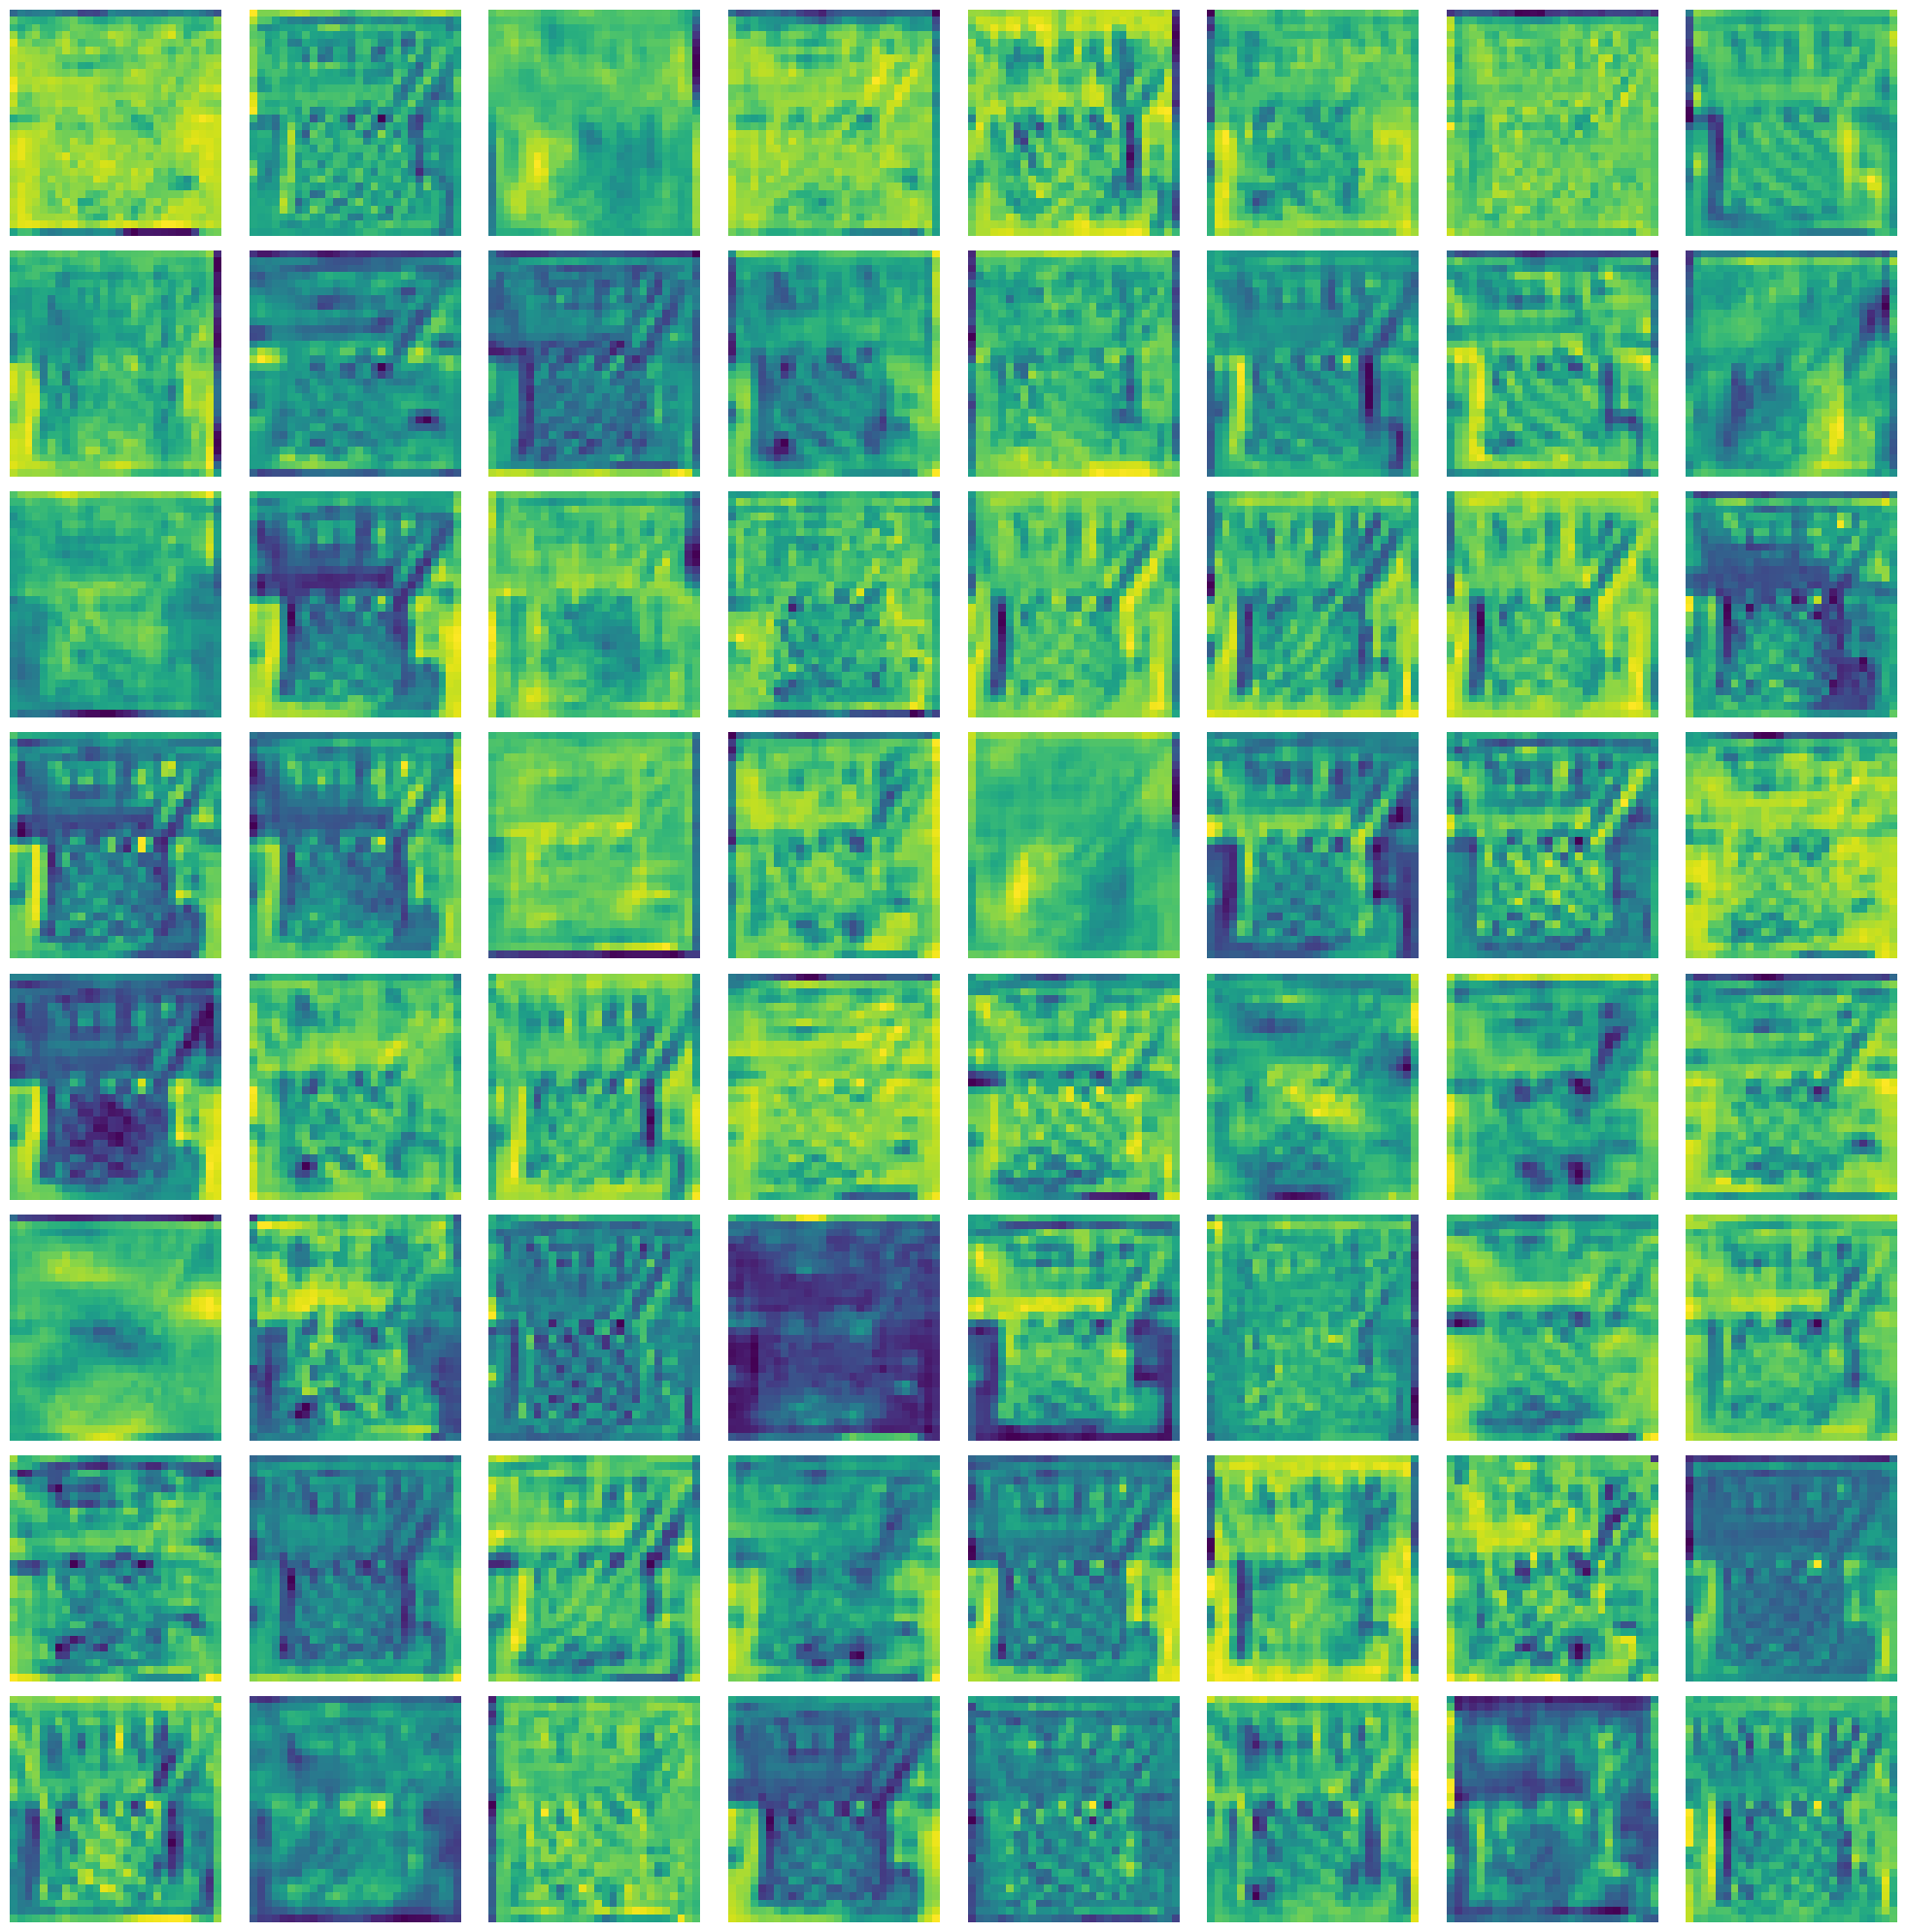

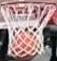

In [15]:
show_feature_map(model, 'classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg' )
Image.open('classification_dataset/1/12_jpg.rf.9e8ec52c88bc5a65e52a1dfd471005af.jpg')

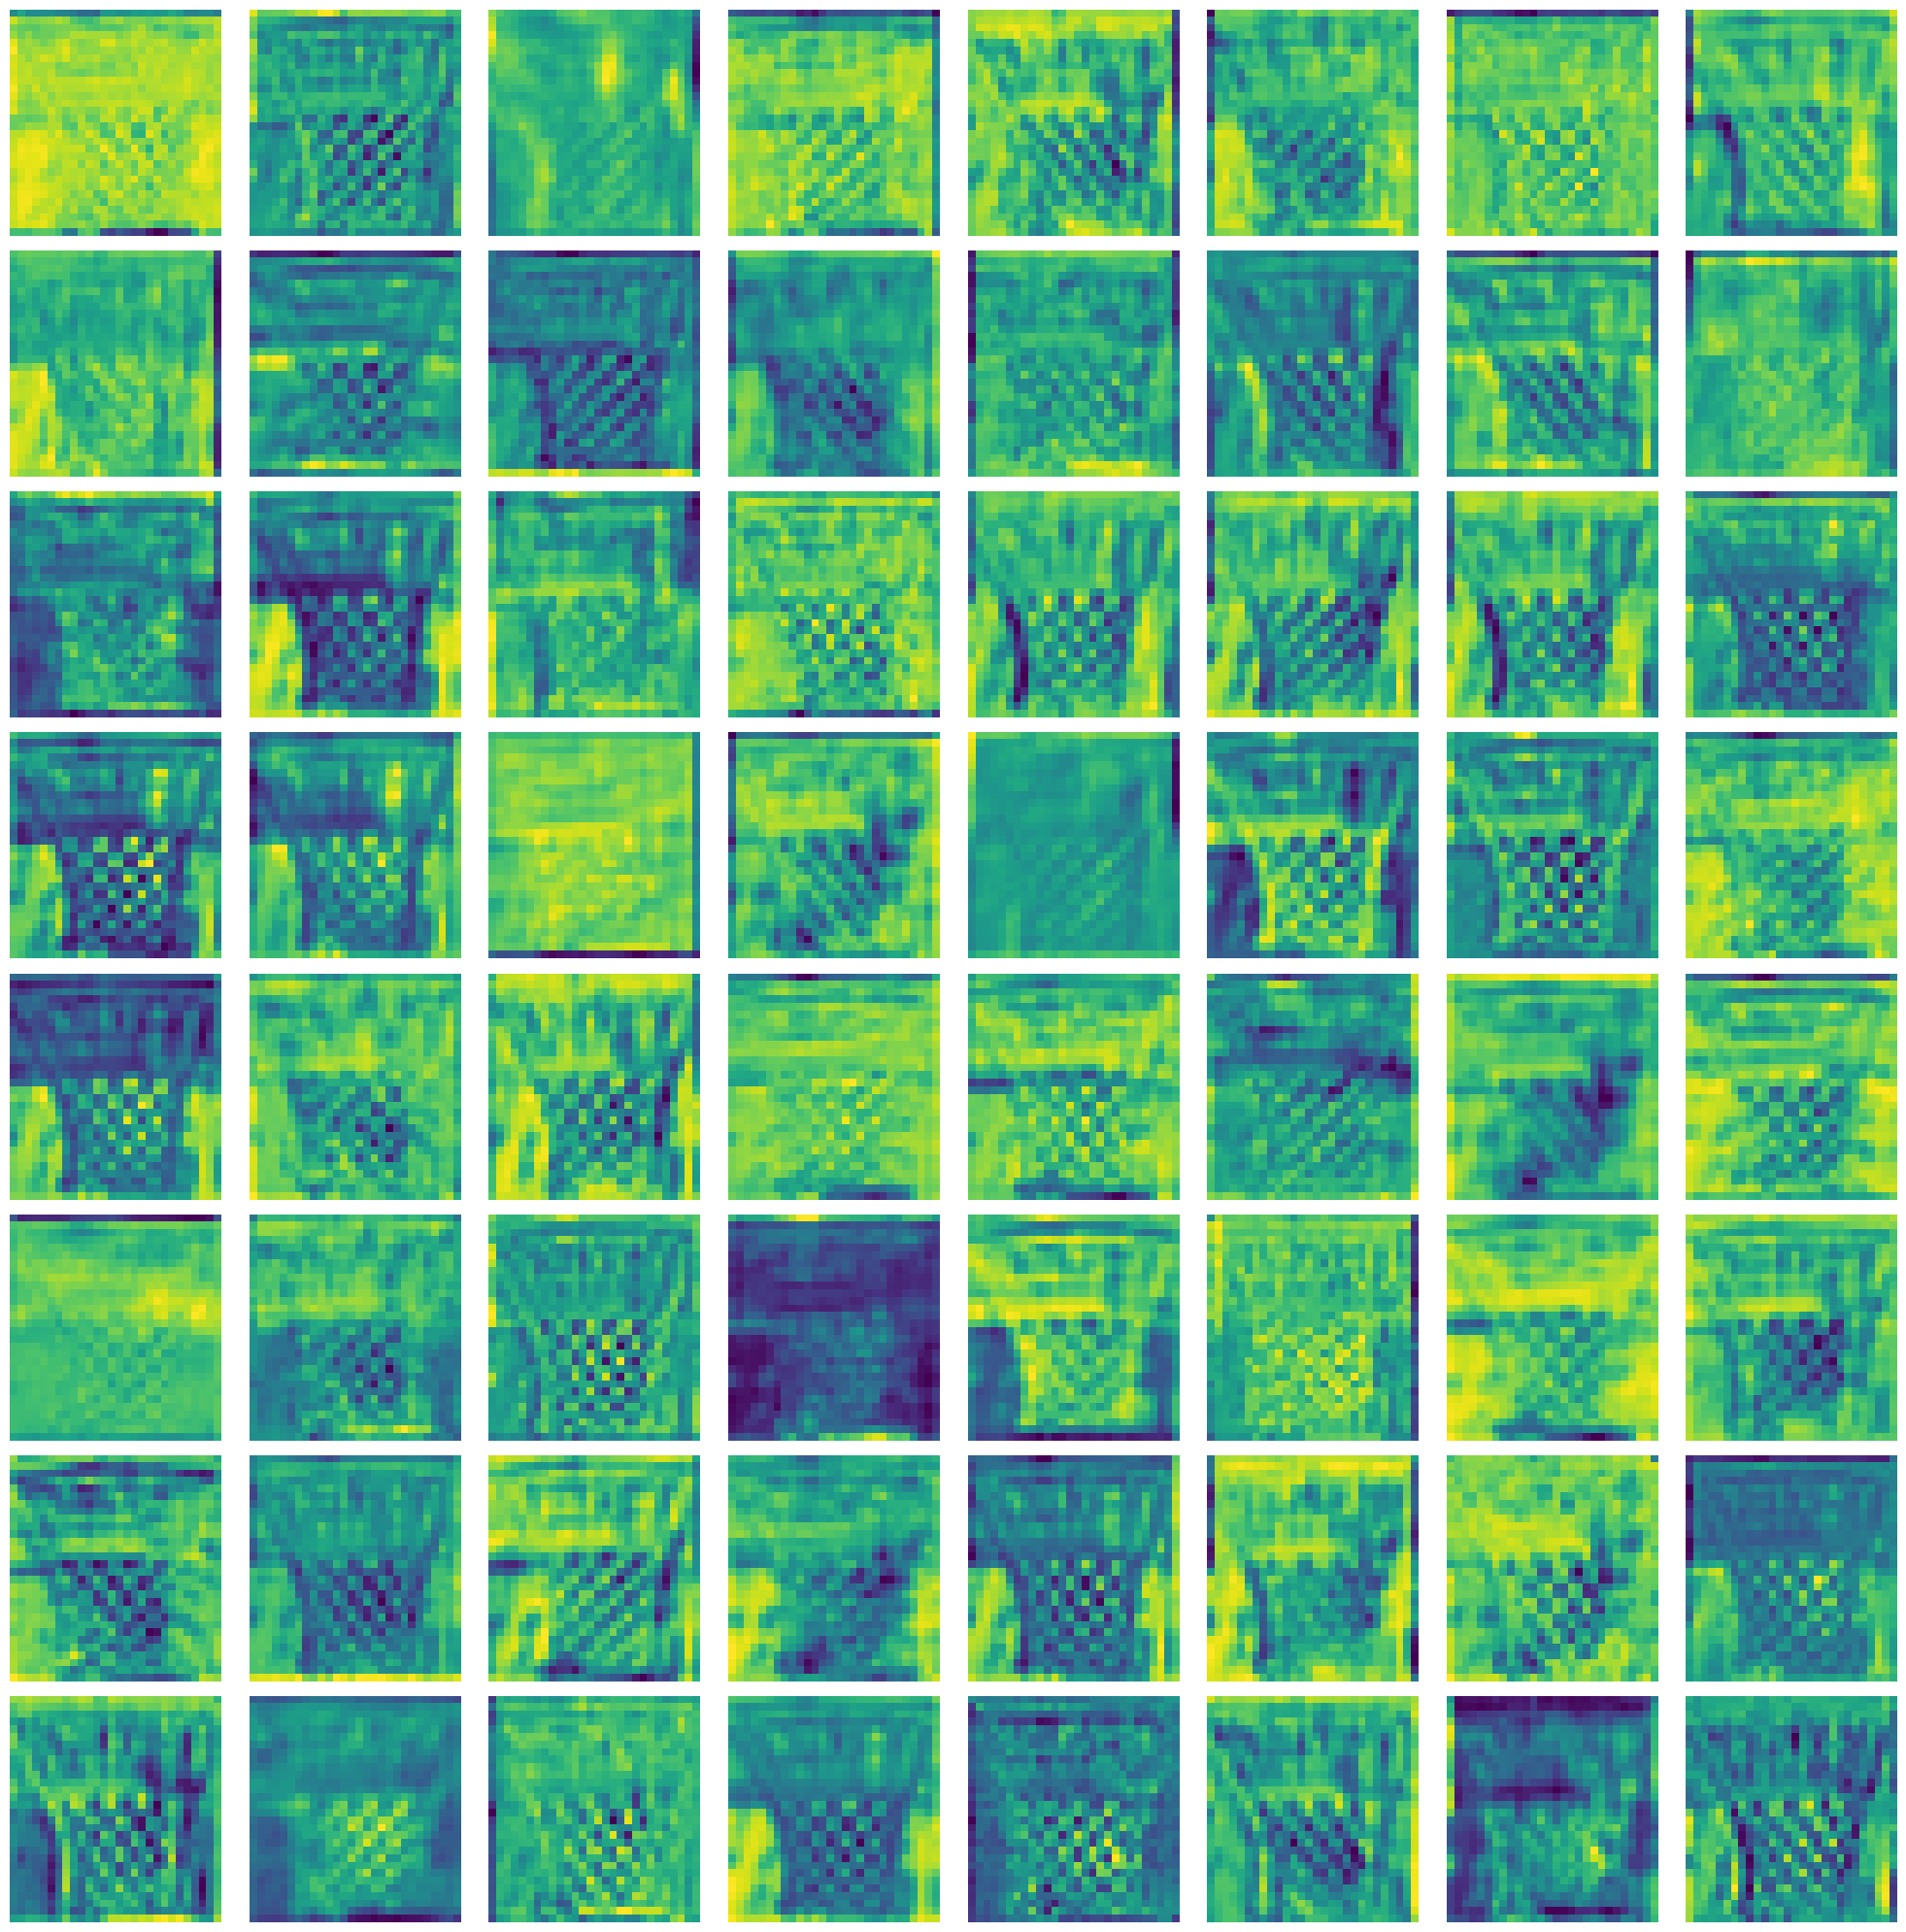

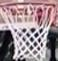

In [16]:
show_feature_map(model, "classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")
# display the image
Image.open("classification_dataset/0/2-2_1_2_jpg.rf.515dea5e560418ca448a1d82c435799d.jpg")

# Tuning Hyperparams


In [ ]:
import ray
from ray import tune
from ray.tune.schedulers import HyperBandScheduler
from training_utils import *

In [ ]:
data_full_path = "/scratch/zw2688/Court_Vision_Model_Dev/data/classification_dataset_groupby_env_split"       
def train_resnet(config):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.to(device)
    train_loader, valid_loader, _ = get_data_loaders(config["batch_size"], config["img_size"],  data_full_path, config["normalize"])
    
    if config["optimizer"] == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config['momentum'], nesterov=config["nestrov"])
    elif config["optimizer"] == "adam":
        optimizer = optim.Adam(model.parameters(), lr=config["lr"])
    else:
        optimizer = optim.RMSprop(model.parameters(), lr=config["lr"])

    criterion = nn.BCEWithLogitsLoss()
    while True:
        train_epoch(model, optimizer, criterion, train_loader, device)
        _, test_accuracy = test(model, criterion, valid_loader, device)
        ray.train.report(metrics = {"accuracy": test_accuracy})
 

In [ ]:
   
    
batch_sizes = [64, 128, 256]
img_sizes = [224, 112, 96]
optimizers = ["sgd", "rmsprop", "adam"]

# hyperband
hyperband_scheduler = HyperBandScheduler(
    time_attr='training_iteration',
    metric='accuracy',
    mode='max',
    max_t=81,
    reduction_factor=3)

hyperband_analysis = tune.run(
    train_resnet,
    name="tuning_cls_resnet18",
    stop={
        "accuracy": 0.92,
        "training_iteration": 100
    },
    resources_per_trial={
        "gpu": 0.5,
        "cpu": 2
    },
    config={
        "lr": tune.loguniform(5e-5, 5e-3),
        "batch_size": tune.grid_search(batch_sizes),
        "optimizer": tune.grid_search(optimizers),
        "img_size": tune.grid_search([224, 112, 96]),
        "nestrov": tune.grid_search([True, False]),
        "momentum": tune.uniform(0.6, 0.95),
        "normalize": tune.grid_search([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                 std=[0.229, 0.224, 0.225]),
            None]),
    },
    scheduler=hyperband_scheduler,
    # local_dir ="/scratch/zw2688/Court_Vision_Model_Dev/tune_results/tuning_cls_resnet18_augmented",
    resume = 'all'
    )

<div class="tuneStatus">
  <div style="display: flex;flex-direction: row">
    <div style="display: flex;flex-direction: column;">
      <h3>Tune Status</h3>
      <table>
<tbody>
<tr><td>Current time:</td><td>2023-12-25 11:35:35</td></tr>
<tr><td>Running for: </td><td>00:25:00.93        </td></tr>
<tr><td>Memory:      </td><td>40.3/377.3 GiB     </td></tr>
</tbody>
</table>
    </div>
    <div class="vDivider"></div>
    <div class="systemInfo">
      <h3>System Info</h3>
      Using HyperBand: num_stopped=42 total_brackets=5<br>Round #0:<br>  Bracket(Max Size (n)=5, Milestone (r)=81, completed=27.4%): {RUNNING: 1, TERMINATED: 4} <br>  Bracket(Max Size (n)=3, Milestone (r)=81, completed=21.4%): {PAUSED: 2, TERMINATED: 6} <br>  Bracket(Max Size (n)=5, Milestone (r)=27, completed=26.3%): {PAUSED: 5, TERMINATED: 10} <br>  Bracket(Max Size (n)=12, Milestone (r)=9, completed=26.2%): {PAUSED: 9, TERMINATED: 25} <br>  Bracket(Max Size (n)=27, Milestone (r)=3, completed=17.8%): {PAUSED: 23, PENDING: 1, RUNNING: 3, TERMINATED: 19} <br>Logical resource usage: 10.0/48 CPUs, 2.5/4 GPUs (0.0/1.0 accelerator_type:RTX)
    </div>
    <div class="vDivider"></div>
<div class="messages">
  <h3>Messages</h3>
  
  ... 88 more trials not shown (31 PAUSED, 56 TERMINATED)
  
</div>
<style>
.messages {
  color: var(--jp-ui-font-color1);
  display: flex;
  flex-direction: column;
  padding-left: 1em;
  overflow-y: auto;
}
.messages h3 {
  font-weight: bold;
}
.vDivider {
  border-left-width: var(--jp-border-width);
  border-left-color: var(--jp-border-color0);
  border-left-style: solid;
  margin: 0.5em 1em 0.5em 1em;
}
</style>

  </div>
  <div class="hDivider"></div>
  <div class="trialStatus">
    <h3>Trial Status</h3>
    <table>
<thead>
<tr><th>Trial name              </th><th>status    </th><th>loc                </th><th style="text-align: right;">  batch_size</th><th style="text-align: right;">  img_size</th><th style="text-align: right;">         lr</th><th style="text-align: right;">  momentum</th><th>nestrov  </th><th>optimizer  </th><th style="text-align: right;">  iter</th><th style="text-align: right;">  total time (s)</th><th style="text-align: right;">  accuracy</th></tr>
</thead>
<tbody>
<tr><td>train_resnet_22b36_00000</td><td>RUNNING   </td><td>10.32.35.78:1758701</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00417535 </td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    15</td><td style="text-align: right;">       1493.53  </td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00076</td><td>RUNNING   </td><td>10.32.35.78:1769809</td><td style="text-align: right;">          64</td><td style="text-align: right;">       112</td><td style="text-align: right;">9.24398e-05</td><td style="text-align: right;">       0.7</td><td>True     </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         28.0012</td><td style="text-align: right;">  0.666667</td></tr>
<tr><td>train_resnet_22b36_00079</td><td>RUNNING   </td><td>10.32.35.78:1770043</td><td style="text-align: right;">          64</td><td style="text-align: right;">        96</td><td style="text-align: right;">0.00455878 </td><td style="text-align: right;">       0.7</td><td>True     </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         18.4259</td><td style="text-align: right;">  0.75    </td></tr>
<tr><td>train_resnet_22b36_00081</td><td>RUNNING   </td><td>10.32.35.78:1766260</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">9.84273e-05</td><td style="text-align: right;">       0.9</td><td>False    </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         15.7612</td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00007</td><td>PAUSED    </td><td>10.32.35.78:1758708</td><td style="text-align: right;">          64</td><td style="text-align: right;">        96</td><td style="text-align: right;">7.05892e-05</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    27</td><td style="text-align: right;">         71.9149</td><td style="text-align: right;">  0.666667</td></tr>
<tr><td>train_resnet_22b36_00008</td><td>PAUSED    </td><td>10.32.35.78:1759389</td><td style="text-align: right;">         128</td><td style="text-align: right;">        96</td><td style="text-align: right;">0.000119394</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    27</td><td style="text-align: right;">         62.0868</td><td style="text-align: right;">  0.868421</td></tr>
<tr><td>train_resnet_22b36_00013</td><td>PAUSED    </td><td>10.32.35.78:1759860</td><td style="text-align: right;">          64</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.000951119</td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        111.693 </td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00014</td><td>PAUSED    </td><td>10.32.35.78:1760010</td><td style="text-align: right;">         128</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.00374332 </td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">         90.1043</td><td style="text-align: right;">  0.881579</td></tr>
<tr><td>train_resnet_22b36_00016</td><td>PAUSED    </td><td>10.32.35.78:1760302</td><td style="text-align: right;">          64</td><td style="text-align: right;">        96</td><td style="text-align: right;">7.71758e-05</td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">         23.0398</td><td style="text-align: right;">  0.833333</td></tr>
<tr><td>train_resnet_22b36_00019</td><td>PAUSED    </td><td>10.32.35.78:1760554</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000101113</td><td style="text-align: right;">       0.7</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        195.414 </td><td style="text-align: right;">  0.916667</td></tr>
<tr><td>train_resnet_22b36_00027</td><td>PAUSED    </td><td>10.32.35.78:1761701</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000147773</td><td style="text-align: right;">       0.9</td><td>False    </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        190.726 </td><td style="text-align: right;">  0.916667</td></tr>
<tr><td>train_resnet_22b36_00029</td><td>PAUSED    </td><td>10.32.35.78:1768086</td><td style="text-align: right;">         128</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00537547 </td><td style="text-align: right;">       0.9</td><td>False    </td><td>sgd        </td><td style="text-align: right;">     9</td><td style="text-align: right;">        167.263 </td><td style="text-align: right;">  0.921053</td></tr>
<tr><td>train_resnet_22b36_00082</td><td>PENDING   </td><td>10.32.35.78:1766317</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00144752 </td><td style="text-align: right;">       0.9</td><td>False    </td><td>rmsprop    </td><td style="text-align: right;">     1</td><td style="text-align: right;">         19.2406</td><td style="text-align: right;">  0.916667</td></tr>
<tr><td>train_resnet_22b36_00001</td><td>TERMINATED</td><td>10.32.35.78:1758702</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000634793</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     6</td><td style="text-align: right;">        589.184 </td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00002</td><td>TERMINATED</td><td>10.32.35.78:1758703</td><td style="text-align: right;">         128</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000137173</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    80</td><td style="text-align: right;">       1490     </td><td style="text-align: right;">  0.881579</td></tr>
<tr><td>train_resnet_22b36_00003</td><td>TERMINATED</td><td>10.32.35.78:1758704</td><td style="text-align: right;">          32</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.000574162</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     4</td><td style="text-align: right;">        123.667 </td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00004</td><td>TERMINATED</td><td>10.32.35.78:1758705</td><td style="text-align: right;">          64</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.000252852</td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">    10</td><td style="text-align: right;">        112.31  </td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00005</td><td>TERMINATED</td><td>10.32.35.78:1758706</td><td style="text-align: right;">         128</td><td style="text-align: right;">       112</td><td style="text-align: right;">0.00756926 </td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     8</td><td style="text-align: right;">         69.4052</td><td style="text-align: right;">  0.934211</td></tr>
<tr><td>train_resnet_22b36_00006</td><td>TERMINATED</td><td>10.32.35.78:1758707</td><td style="text-align: right;">          32</td><td style="text-align: right;">        96</td><td style="text-align: right;">0.00337975 </td><td style="text-align: right;">       0.9</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     3</td><td style="text-align: right;">         80.6108</td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00009</td><td>TERMINATED</td><td>10.32.35.78:1759430</td><td style="text-align: right;">          32</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.000443854</td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     4</td><td style="text-align: right;">         92.9186</td><td style="text-align: right;">  1       </td></tr>
<tr><td>train_resnet_22b36_00010</td><td>TERMINATED</td><td>10.32.35.78:1759513</td><td style="text-align: right;">          64</td><td style="text-align: right;">       224</td><td style="text-align: right;">0.00269921 </td><td style="text-align: right;">       0.8</td><td>True     </td><td>sgd        </td><td style="text-align: right;">     8</td><td style="text-align: right;">        761.078 </td><td style="text-align: right;">  1       </td></tr>
</tbody>
</table>
  </div>
</div>
<style>
.tuneStatus {
  color: var(--jp-ui-font-color1);
}
.tuneStatus .systemInfo {
  display: flex;
  flex-direction: column;
}
.tuneStatus td {
  white-space: nowrap;
}
.tuneStatus .trialStatus {
  display: flex;
  flex-direction: column;
}
.tuneStatus h3 {
  font-weight: bold;
}
.tuneStatus .hDivider {
  border-bottom-width: var(--jp-border-width);
  border-bottom-color: var(--jp-border-color0);
  border-bottom-style: solid;
}
.tuneStatus .vDivider {
  border-left-width: var(--jp-border-width);
  border-left-color: var(--jp-border-color0);
  border-left-style: solid;
  margin: 0.5em 1em 0.5em 1em;
}
</style>


In [1]:
tuner = tune.Tuner.restore(
    "/scratch/zw2688/Court_Vision_Model_Dev/tune_results/tuning_cls_resnet18_augmented",
    trainable = train_resnet,
    resume_unfinished = True
)

NameError: name 'tune' is not defined

In [8]:
from ray.tune import ExperimentAnalysis

In [22]:
ExperimentAnalysis


{'lr': 0.003496941651621201,
 'batch_size': 64,
 'optimizer': 'sgd',
 'img_size': 224,
 'nestrov': True,
 'momentum': 0.7880866514607588}

In [10]:
storage_path = "/scratch/zw2688/Court_Vision_Model_Dev/tune_results"
exp_name = "tuning_cls_resnet18_augmented"
experiment_path = os.path.join(storage_path, exp_name)
print(f"Loading results from {experiment_path}...")
r = ExperimentAnalysis(experiment_path)



Loading results from /scratch/zw2688/Court_Vision_Model_Dev/tune_results/tuning_cls_resnet18_augmented...


2024-01-03 11:26:31,823	WARNING experiment_analysis.py:185 -- Failed to fetch metrics for 52 trial(s):
- train_resnet_21f63_00016: FileNotFoundError('Could not fetch metrics for train_resnet_21f63_00016: both result.json and progress.csv were not found at /scratch/zw2688/Court_Vision_Model_Dev/tune_results/tuning_cls_resnet18_augmented/train_resnet_21f63_00016_16_batch_size=128,img_size=96,lr=0.0034,momentum=0.9016,nestrov=False,normalize=ref_ph_5baf1578,optimizer_2024-01-02_21-16-47')
- train_resnet_21f63_00034: FileNotFoundError('Could not fetch metrics for train_resnet_21f63_00034: both result.json and progress.csv were not found at /scratch/zw2688/Court_Vision_Model_Dev/tune_results/tuning_cls_resnet18_augmented/train_resnet_21f63_00034_34_batch_size=128,img_size=96,lr=0.0026,momentum=0.6587,nestrov=False,normalize=None,optimizer=sgd_2024-01-02_21-16-47')
- train_resnet_21f63_00033: FileNotFoundError('Could not fetch metrics for train_resnet_21f63_00033: both result.json and progre

In [14]:
r.get_best_config(metric="accuracy", mode="max")

{'lr': 0.004922064284606748,
 'batch_size': 128,
 'optimizer': 'sgd',
 'img_size': 224,
 'nestrov': True,
 'momentum': 0.7510258908870537,
 'normalize': Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])}